# Bias and Fairness

Let's first consider a synthetic dataset with imbalanced classes.
Group A is gaussian distributed with mean -1 and standard deviation 1.
Group B is gaussian distributed with mean 1 and standard deviation 1.
Suppose we want to train a logistic regression classifier to distinguish between the two groups. In theory, the decision boundary should be at 0.

However, the dataset is imbalanced, with 1000 samples from group A and 100 samples from group B.


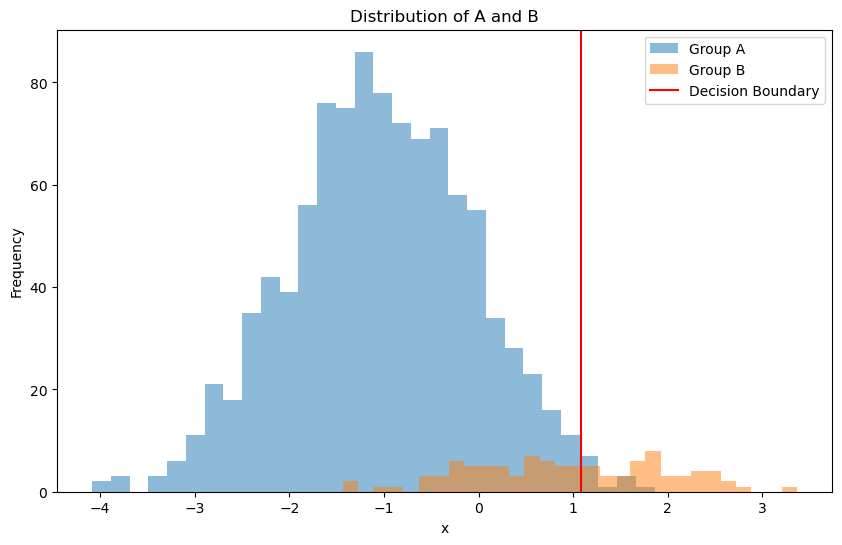

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix


# Generating data for a 1D Gaussian Mixture
np.random.seed(7)
std = 1
n_A = 1000
n_B = 100
group_A = np.random.normal(-1, std, n_A)  # Group A: mean = -1, std = 1, 1000 samples
group_B = np.random.normal(1, std, n_B)    # Group B: mean = 1, std = 1, 100 samples

# Labels for the groups
labels_A = np.zeros(n_A)    # Group A labeled as 0
labels_B = np.ones(n_B)    # Group B labeled as 1

# Combining the data
data = np.concatenate([group_A, group_B])
labels = np.concatenate([labels_A, labels_B])

# Visualizing the data
plt.figure(figsize=(10, 6))
plt.hist(group_A, bins=30, alpha=0.5, label='Group A')
plt.hist(group_B, bins=30, alpha=0.5, label='Group B')
plt.title('Distribution of A and B')
plt.xlabel('x')
plt.ylabel('Frequency')
plt.legend()

# Applying Logistic Regression
X = data.reshape(-1, 1)
y = labels
model = LogisticRegression()
model.fit(X, y)

# Calculate the decision boundary: intercept + coef*x = 0
decision_boundary = -model.intercept_ / model.coef_[0]

# Plotting the decision boundary
plt.axvline(x=decision_boundary, color='red', label='Decision Boundary')
plt.legend()

# Show the plot
plt.show()

Because of the imbalance, the classifier works well on group A but poorly on group B.

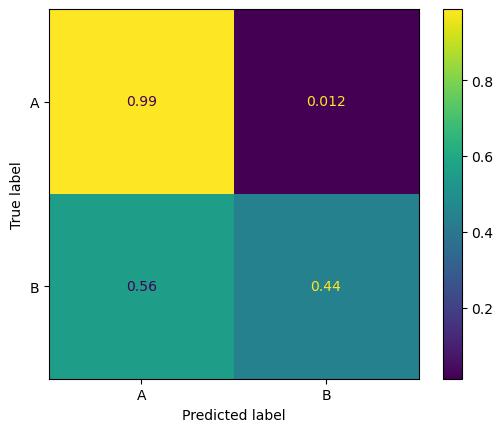

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay

# Predicting the labels
pred_group_B = model.predict(X)

is_group_B = labels == 1

# Confusion matrix for group B
conf_matrix_B = confusion_matrix(is_group_B, pred_group_B, normalize='true')

disp_B = ConfusionMatrixDisplay(conf_matrix_B, display_labels=['A', 'B'])
disp_B.plot()


One way to address this issue is to use a balanced dataset. We can do this by resampling the minority class (group B) to have the same number of samples as the majority class (group A).

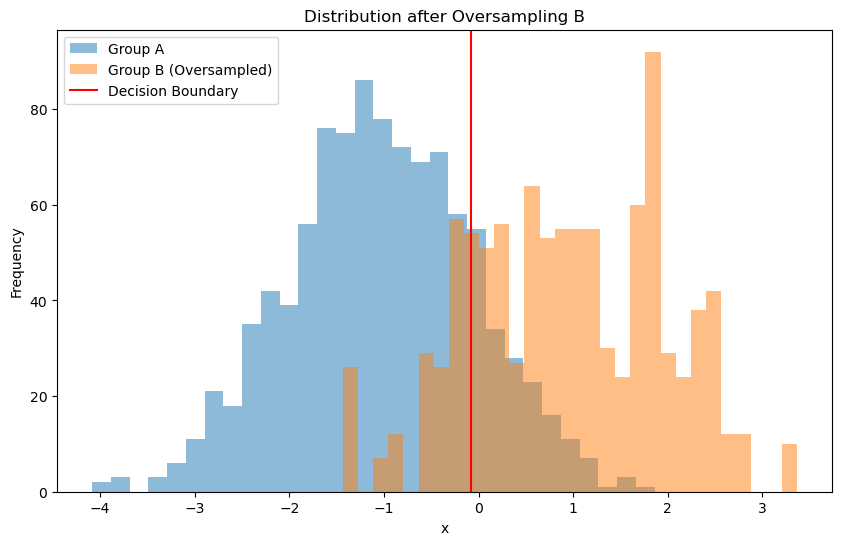

In [26]:
from sklearn.utils import resample

# Resampling the data to mitigate bias
# Oversampling Group B
group_B_oversampled = resample(group_B,
                               replace=True,
                               n_samples=len(group_A),  # match the number of samples in Group A
                               random_state=0)

labels_B_oversampled = np.ones(len(group_B_oversampled))

# Combining the oversampled data
data_oversampled = np.concatenate([group_A, group_B_oversampled])
labels_oversampled = np.concatenate([labels_A, labels_B_oversampled])

# Visualizing the oversampled data
plt.figure(figsize=(10, 6))
plt.hist(group_A, bins=30, alpha=0.5, label='Group A')
plt.hist(group_B_oversampled, bins=30, alpha=0.5, label='Group B (Oversampled)')
plt.title('Distribution after Oversampling B')
plt.xlabel('x')
plt.ylabel('Frequency')

# Retraining logistic regression with the oversampled data
X_oversampled = data_oversampled.reshape(-1, 1)
y_oversampled = labels_oversampled
model_oversampled = LogisticRegression()
model_oversampled.fit(X_oversampled, y_oversampled)

decision_boundary = -model_oversampled.intercept_ / model_oversampled.coef_[0]

# Plotting the decision boundary
plt.axvline(x=decision_boundary, color='red', label='Decision Boundary')
plt.legend()
plt.show()



Another way is to reweight the data. 

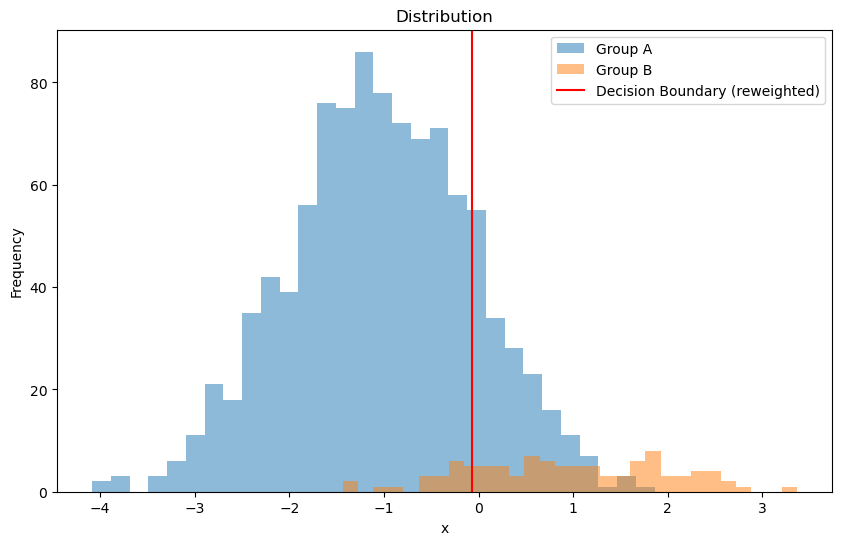

In [30]:
# Assign weights to mitigate bias
weight_A = n_B / (n_A + n_B) # there is more of A, so we want to weight it less
weight_B = n_A / (n_A + n_B) # there is less of B, so we want to weight it more

weights = np.where(labels == 0, weight_A, weight_B)

# Visualizing the data
plt.figure(figsize=(10, 6))
plt.hist(group_A, bins=30, alpha=0.5, label='Group A')
plt.hist(group_B, bins=30, alpha=0.5, label='Group B')
plt.title('Distribution')
plt.xlabel('x')
plt.ylabel('Frequency')

# Training logistic regression with custom weights
X = data.reshape(-1, 1)
y = labels
model_weighted = LogisticRegression()
model_weighted.fit(X, y, sample_weight=weights)

# Calculate the decision boundary for the weighted model
decision_boundary_weighted = -model_weighted.intercept_ / model_weighted.coef_[0]

# Plotting the decision boundary
plt.axvline(x=decision_boundary_weighted, color='red', label='Decision Boundary (reweighted)')
plt.legend()
plt.show()


We can also post process the decision boundary to make it more robust

Here is an criteria of fairness: the true positive rate should be the same for both groups. Therefore, we can search for different decision boundaries that satisfy this criteria.

In [4]:
# # Training a logistic regression model
# model = LogisticRegression()
# X = data.reshape(-1, 1)
# model.fit(X, labels)

LogisticRegression()

Optimal Threshold for Group A: 0.09090909090909105


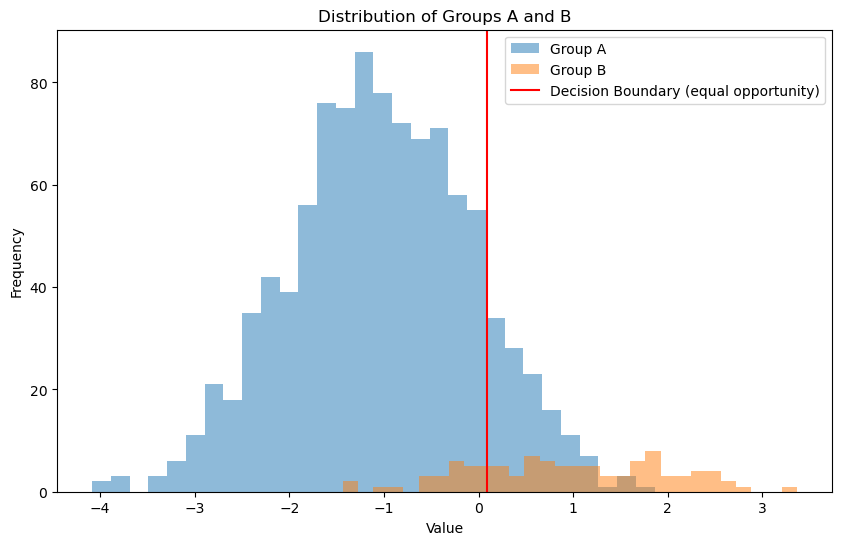

In [6]:


# Function to calculate TPR for a given threshold
def calculate_tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    TP = cm[1, 1]
    FN = cm[1, 0]
    return TP / (TP + FN)

# Function to find optimal threshold for equal opportunity
probabilities = model.predict_proba(X)[:, 1]
thresholds = np.linspace(-1, 1, 100)
best_diff = float('inf')
best_threshold = None



for threshold in thresholds:
    
    # Assigning group labels based on the threshold
    group_A_pred = probabilities[mask_group_A] > threshold
    group_B_pred = probabilities[mask_group_B] < threshold

    is_group_A = labels[mask_group_A] == 0
    is_group_B = labels[mask_group_B] == 1

    # Calculating TPR for each group
    tpr_A = calculate_tpr(is_group_A, group_A_pred)
    tpr_B = calculate_tpr(is_group_B, group_B_pred)
    

    # Measure the absolute difference between TPRs
    diff = abs(tpr_A - tpr_B)
    if diff < best_diff:
        best_diff = diff
        best_threshold = threshold

# Finding and printing optimal thresholds
print(f"Optimal Threshold for Group A: {best_threshold}")


# Visualizing the data
plt.figure(figsize=(10, 6))
plt.hist(group_A, bins=30, alpha=0.5, label='Group A')
plt.hist(group_B, bins=30, alpha=0.5, label='Group B')
plt.title('Distribution of Groups A and B')
plt.xlabel('Value')
plt.ylabel('Frequency')
# Plotting the decision boundary
plt.axvline(x=best_threshold, color='red', label='Decision Boundary (equal opportunity)')
plt.legend()
plt.show()
